In [5]:
import os
from dotenv import load_dotenv

load_dotenv()  # .env 파일 읽어오기

PINECONE_API_KEY=os.environ['PINECONE_API_KEY']

## index 생성

In [6]:
from pinecone import Pinecone
# 클라이언트 생성
pinecone_client=Pinecone(api_key=PINECONE_API_KEY)

In [7]:
pinecone_client

In [14]:
index = pinecone_client.Index("embedding-3d")


In [13]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='embedding-3d',
    dimension=3,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

PineconeApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2025-04', 'x-cloud-trace-context': '7fb07d39d0ad34801a6e235ab9f25328', 'date': 'Tue, 09 Sep 2025 01:02:42 GMT', 'server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}


In [11]:
index=pinecone_client.Index('embedding-3d')
index

In [15]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

In [16]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


## Pinecone data 형식

In [17]:
index.upsert(  
  vectors=[{ 'id' : 'vec1' , 'values' :[1.0, 1.5, 2.0] , 'metadata' :   {'genre':'drama'}},  
    { 'id' : 'vec2' , 'values' :[2.0, 1.5, 0.5] , 'metadata' : {'genre':'action'}},  
    { 'id' : 'vec3' , 'values' :[0.1, 0.3, 0.5] , 'metadata' : {'genre':'drama'}},  
    { 'id' : 'vec4' , 'values' :[1.0, 2.5, 3.5] , 'metadata' : {'genre':'action'}},  
    { 'id' : 'vec5' , 'values' :[3.0, 1.2, 1.3] , 'metadata' : {'genre':'action'}},  
    { 'id' : 'vec6' , 'values' :[0.3, 1.1, 2.5] , 'metadata' : {'genre':'drama'}},  
    ],  
  namespace='embedding-3d-ns1'  
  ) #update + insert  

{'upserted_count': 6}

In [18]:
index.describe_index_stats()

{'dimension': 3,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}

### id list

In [19]:
for ids in index.list(namespace='embedding-3d-ns1'):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


## query

In [20]:
response=index.query(
    namespace='embedding-3d-ns1',
    vector=[0.1,0.4,0.7],
    top_k=3,
    include_values=True,
    include_metadata=True,
    filter={'genre':{'$eq':'drama'}}
    
)
response

{'matches': [{'id': 'vec3',
              'metadata': {'genre': 'drama'},
              'score': 1.00008953,
              'values': [0.1, 0.3, 0.5]},
             {'id': 'vec6',
              'metadata': {'genre': 'drama'},
              'score': 0.99550879,
              'values': [0.3, 1.1, 2.5]},
             {'id': 'vec1',
              'metadata': {'genre': 'drama'},
              'score': 0.961182,
              'values': [1.0, 1.5, 2.0]}],
 'namespace': 'embedding-3d-ns1',
 'usage': {'read_units': 1}}

In [21]:
ns='embedding-3d-ns1'
for ids in index.list(namespace=ns):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [22]:
from itertools import chain
all_ids=list(chain.from_iterable(index.list(namespace=ns)))
resp=index.fetch(ids=all_ids, namespace=ns)
resp

FetchResponse(namespace='embedding-3d-ns1', vectors={'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None), 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None), 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None), 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None), 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None), 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None)}, usage={'read_units': 1})

In [23]:
resp.vectors

{'vec6': Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None),
 'vec1': Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None),
 'vec2': Vector(id='vec2', values=[2.0, 1.5, 0.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec4': Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None),
 'vec5': Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None),
 'vec3': Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None)}

In [24]:
for vid, v in resp.vectors.items():
    vid, v.values

## page

In [26]:
for id_page in index.list(namespace=ns):
    resp = index.fetch(ids=id_page, namespace=ns)
    for vid,v in resp.vectors.items():
        print(vid, v.values)

vec5 [3.0, 1.2, 1.3]
vec3 [0.1, 0.3, 0.5]
vec1 [1.0, 1.5, 2.0]
vec2 [2.0, 1.5, 0.5]
vec4 [1.0, 2.5, 3.5]
vec6 [0.3, 1.1, 2.5]


In [27]:
ids=list(resp.vectors.keys())
values=[vec.values for vec in resp.vectors.values()]

In [30]:
ids.append('qv')
values.append([0.1, 0.3, 0.7]) #차원일치

In [32]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------- ----- 7.1/8.1 MB 36.4 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 33.6 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 42.4 MB/s  0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- ---------------------

IndexError: list index out of range

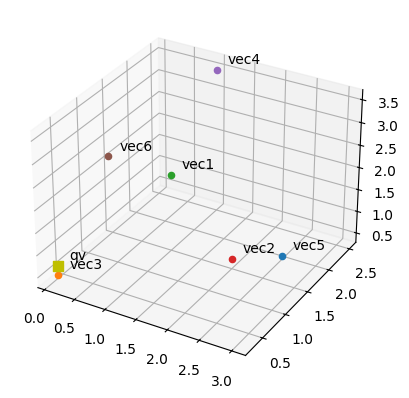

In [33]:
import matplotlib.pyplot as plt

#3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

#축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

#플롯을 표시합니다.
plt.show()

## 임베딩 시도  

1. name: "quickstart" 서버리스 인덱스 생성     
2. dim: 1024    

3. data = [  
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},  
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},  
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},  
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},  
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악,  로널드 웨인에 의해 파트너십으로 설립되었습니다."}  
]

## 임베딩 모델  
 1. multilingual-e5-large upsert()     
 2. describe_index_stats()     
 3. query_vector : "애플이라는 기술 회사에 대해 알려주세요."     
 4. index.query()    

### 1. 라이브러리 및 pinecone 초기화

In [42]:
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer

# Pinecone API 키로 초기화
pc = Pinecone(api_key="PINECONE_API_KEY")

# 임베딩 모델 로드
model = SentenceTransformer("intfloat/multilingual-e5-large")

c:\Users\Admin\miniconda3\envs\prompting_env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--intfloat--multilingual-e5-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back

### 2. 서버리스 인덱스 생성

In [ ]:
from pinecone import ServerlessSpec
pinecone_client.create_index(
    name='quickstart',
    dimension=1024,
    metric='cosine',
    spec=ServerlessSpec(
        cloud='aws',
        region='us-east-1'
    )
)

In [43]:
index=pinecone_client.Index('quickstart')

In [44]:
index.describe_index_stats() #현재 벡터가 하나도 업서트되지 않은 상태

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

'dimension': 1024,         # 인덱스 차원 (multilingual-e5-large와 일치)  
 'index_fullness': 0.0,     # 저장 공간 사용률 (0이면 비어있음)  
 'metric': 'cosine',        # 유사도 계산 방식  
 'namespaces': {},          # 현재 네임스페이스 없음 (기본값)  
 'total_vector_count': 0,   # 저장된 벡터 개수 (0 → 아직 데이터 없음)  
 'vector_type': 'dense'     # 밀집 벡터 저장용 인덱스  

### 3. 데이터 준비

In [45]:
data = [
    {"id": "vec1", "text": "사과는 달콤하고 아삭한 식감으로 유명한 인기 있는 과일입니다."},
    {"id": "vec2", "text": "애플이라는 기술 회사는 아이폰과 같은 혁신적인 제품으로 유명합니다."},
    {"id": "vec3", "text": "많은 사람들이 건강한 간식으로 사과를 즐겨 먹습니다."},
    {"id": "vec4", "text": "애플 주식회사는 세련된 디자인과 사용자 친화적인 인터페이스로 기술 산업을 혁신했습니다."},
    {"id": "vec5", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "vec6", "text": "애플 컴퓨터 회사는 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

### 4.텍스트 -> 임베딩

In [ ]:
# 데이터 업서트 (metadata 포함)
vectors = [
    {
        "id": item["id"],
        "values": model.encode(item["text"]).tolist(),
        "metadata": {"text": item["text"]}
    }
    for item in data
]



{'upserted_count': 6}

### 5. 파인콘에 업서트

In [54]:
# 인덱스에 벡터 업서트
index.upsert(vectors=vectors)

{'upserted_count': 6}

### 6.인덱스 상태확인

In [55]:
print(index.describe_index_stats())

{'dimension': 1024,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 6}},
 'total_vector_count': 6,
 'vector_type': 'dense'}


### 7. 쿼리실행

In [ ]:
query_text = "애플이라는 기술 회사에 대해 알려주세요."
query_vector = model.encode([query_text]).tolist()[0]  #문장을 1024차원 벡터로 변환(임베딩)

result = index.query(
    vector=query_vector,
    top_k=3,
    include_values=False
)
print(result)

{'matches': [{'id': 'vec2', 'score': 0.905901, 'values': []},
             {'id': 'vec4', 'score': 0.886488914, 'values': []},
             {'id': 'vec6', 'score': 0.853724539, 'values': []}],
 'namespace': '',
 'usage': {'read_units': 1}}


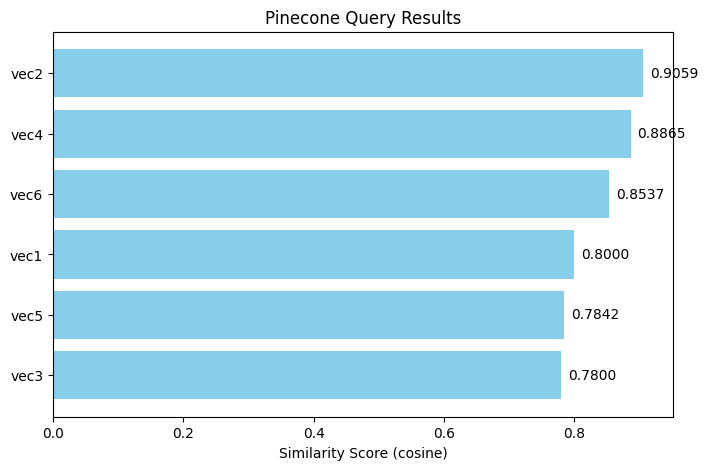

In [51]:
import matplotlib.pyplot as plt

# 예: query 결과
response = index.query(
    vector=query_vector,
    top_k=6,
    include_values=False,
    include_metadata=True
)

# 결과에서 id와 점수 추출
ids = [match['id'] for match in response['matches']]
scores = [match['score'] for match in response['matches']]

# 시각화
plt.figure(figsize=(8, 5))
bars = plt.barh(ids, scores, color="skyblue")
plt.xlabel("Similarity Score (cosine)")
plt.title("Pinecone Query Results")

# 점수 레이블 표시
for bar, score in zip(bars, scores):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{score:.4f}", va='center')

plt.gca().invert_yaxis()  
plt.show()


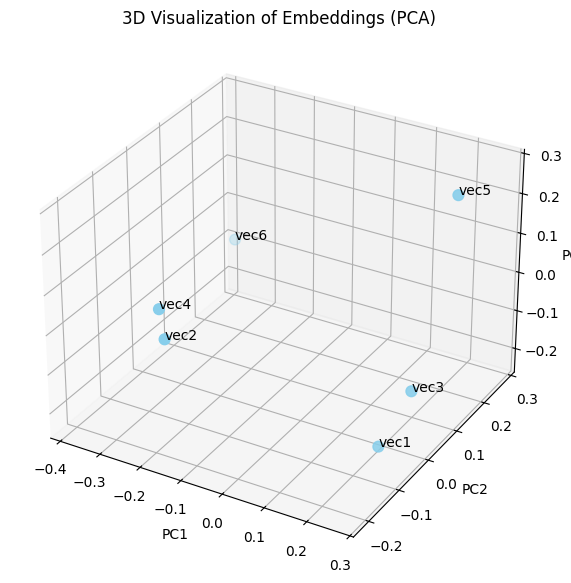

In [52]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# 데이터 벡터화
ids = [item["id"] for item in data]
texts = [item["text"] for item in data]
embeddings = [model.encode(item["text"]) for item in data]

# 1024차원을 3차원으로 축소 (PCA 사용)
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)

# 3D 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

xs, ys, zs = reduced[:,0], reduced[:,1], reduced[:,2]
ax.scatter(xs, ys, zs, c="skyblue", s=60)

# 각 점에 라벨 붙이기 (vec id)
for i, txt in enumerate(ids):
    ax.text(xs[i], ys[i], zs[i], txt, fontsize=10)

ax.set_title("3D Visualization of Embeddings (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()


1. 높을수록 두 벡터간 유사도 높음
2. Pinecone의 score는 쿼리 벡터와 DB 벡터 간의 유사도
3. 벡터 검색에 특화된 DB인 pinecone에